# 1. SETTINGS

In [97]:
# libraries
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

In [98]:
# garbage collection
import gc
gc.enable()

In [99]:
# pandas options
pd.set_option("display.max_columns", None)

In [100]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [101]:
# random settings
seed = 42

# 2. PREPARATIONS

In [102]:
# dataset
data = "v1"

In [103]:
# import data
train = pd.read_csv("../data/prepared/train_" + str(data) + ".csv")
test  = pd.read_csv("../data/prepared/test_"  + str(data) + ".csv")
y     = pd.read_csv("../data/prepared/y_"     + str(data) + ".csv")

In [104]:
# sort data
train = train.sort_values("SK_ID_CURR")
y     = y.sort_values("SK_ID_CURR")

In [105]:
# extract target
y = y["TARGET"]

In [106]:
# exclude features
excluded_feats = ["SK_ID_CURR"]
features = [f for f in train.columns if f not in excluded_feats]

In [107]:
# check dimensions
print(train[features].shape)
print(test[features].shape)

(307511, 1829)
(48744, 1829)


In [108]:
### PARAMETERS

# parallel settings
cores = 10

# learner settings
metric   = "auc"
verbose  = 500
stopping = 300

# CV settings
num_folds = 5
shuffle   = True

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = 10000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = seed,
                         num_threads      = cores)

# 3. CROSS-VALIDATION

## 3.1. ALL FEATURES

In [109]:
# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)

# placeholders
valid_aucs_cv = np.zeros(num_folds) 
test_preds_cv = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()

In [110]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    
    # train lightGBM
    gbm = gbm.fit(trn_x, trn_y, 
                  eval_set = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric = metric, 
                  verbose = verbose, 
                  early_stopping_rounds = stopping)
    
    # save number of iterations
    num_iter_cv = gbm.best_iteration_
    
    # predictions
    valid_preds_cv = gbm.predict_proba(val_x, num_iteration = num_iter_cv)[:, 1]
    valid_aucs_cv[n_fold] = roc_auc_score(val_y, valid_preds_cv)
    test_preds_cv += gbm.predict_proba(test[features], num_iteration = num_iter_cv)[:, 1] / folds.n_splits 
    
    # importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["Importance"] = gbm.feature_importances_
    fold_importance_df["Fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
    
    # print performance
    print("----------------------")
    print("Fold%2d AUC: %.6f" % (n_fold + 1, valid_aucs_cv[n_fold]))
    print("----------------------")
    print("")
    
    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
# print overall performance    
auc = np.mean(valid_aucs_cv)
print("Cross-Validation AUC score %.6f" % np.mean(valid_aucs_cv))

Training until validation scores don't improve for 300 rounds.
[500]	training's auc: 0.811736	valid_1's auc: 0.76831
[1000]	training's auc: 0.844032	valid_1's auc: 0.780045
[1500]	training's auc: 0.865157	valid_1's auc: 0.784722
[2000]	training's auc: 0.881048	valid_1's auc: 0.787418
[2500]	training's auc: 0.89428	valid_1's auc: 0.78912
[3000]	training's auc: 0.905052	valid_1's auc: 0.790085
[3500]	training's auc: 0.914893	valid_1's auc: 0.790844
[4000]	training's auc: 0.923638	valid_1's auc: 0.791273
[4500]	training's auc: 0.931613	valid_1's auc: 0.791653
[5000]	training's auc: 0.938625	valid_1's auc: 0.791896
[5500]	training's auc: 0.945063	valid_1's auc: 0.792001
Early stopping, best iteration is:
[5674]	training's auc: 0.947317	valid_1's auc: 0.79211
----------------------
Fold 1 AUC: 0.792119
----------------------

Training until validation scores don't improve for 300 rounds.
[500]	training's auc: 0.811588	valid_1's auc: 0.771135
[1000]	training's auc: 0.843654	valid_1's auc: 0.

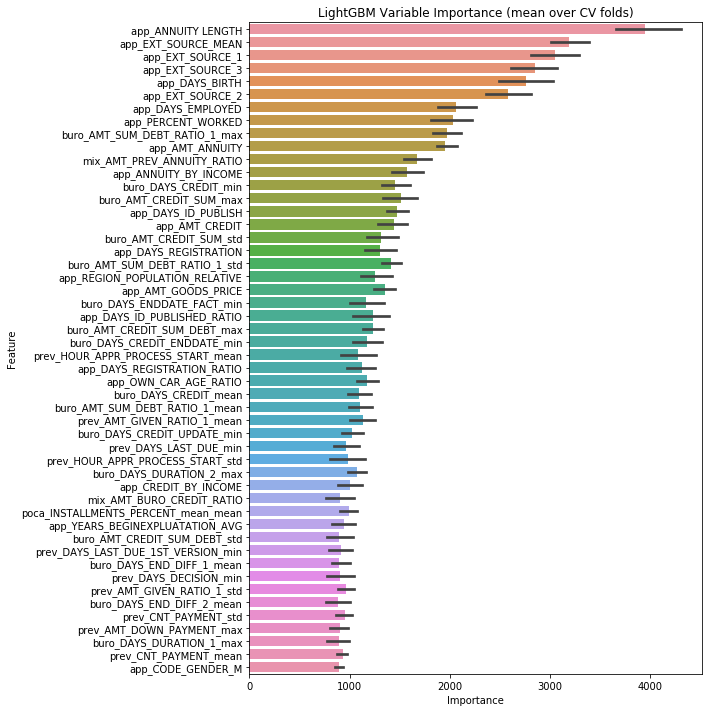

In [124]:
##### VARIABLE IMPORTANCE

# load importance    
top_feats = 50
cols = feature_importance_df[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by = "Importance", ascending = False)[0:top_feats].index
importance = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
# plot variable importance
plt.figure(figsize = (10, 10))
sns.barplot(x = "Importance", y = "Feature", data = importance.sort_values(by = "Importance", ascending = False))
plt.title('LightGBM Variable Importance (mean over CV folds)')
plt.tight_layout()

# save plot as pdf
plt.savefig("../var_importance.pdf")

## 3.2. TOP FEATURES

In [126]:
# keep top features
top = 500
cols = feature_importance_df[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by = "Importance", ascending = False)[0:top].index
importance = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
features = list(importance.groupby("Feature").Importance.mean().sort_values(ascending = False).index)

In [127]:
# check dimensions
print(train[features].shape)
print(test[features].shape)

(307511, 500)
(48744, 500)


In [128]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    
    # train lightGBM
    gbm = gbm.fit(trn_x, trn_y, 
                  eval_set = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric = metric, 
                  verbose = verbose, 
                  early_stopping_rounds = stopping)
    
    # save number of iterations
    num_iter_cv = gbm.best_iteration_
    
    # predictions
    valid_preds_cv = gbm.predict_proba(val_x, num_iteration = num_iter_cv)[:, 1]
    valid_aucs_cv[n_fold] = roc_auc_score(val_y, valid_preds_cv)
    test_preds_cv += gbm.predict_proba(test[features], num_iteration = num_iter_cv)[:, 1] / folds.n_splits
    
    # print performance
    print("----------------------")
    print("Fold%2d AUC: %.6f" % (n_fold + 1, valid_aucs_cv[n_fold]))
    print("----------------------")
    print("")

    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
# print overall performance    
auc = np.mean(valid_aucs_cv)
print("Cross-Validation AUC score %.6f" % auc)

Training until validation scores don't improve for 300 rounds.
[500]	training's auc: 0.81139	valid_1's auc: 0.768437
[1000]	training's auc: 0.843425	valid_1's auc: 0.780076
[1500]	training's auc: 0.865155	valid_1's auc: 0.784949
[2000]	training's auc: 0.881823	valid_1's auc: 0.787479
[2500]	training's auc: 0.895716	valid_1's auc: 0.788807
[3000]	training's auc: 0.90801	valid_1's auc: 0.789684
[3500]	training's auc: 0.918692	valid_1's auc: 0.790373
[4000]	training's auc: 0.927622	valid_1's auc: 0.790853
[4500]	training's auc: 0.936054	valid_1's auc: 0.791146
[5000]	training's auc: 0.943315	valid_1's auc: 0.79137
[5500]	training's auc: 0.950146	valid_1's auc: 0.791516
[6000]	training's auc: 0.956126	valid_1's auc: 0.791547
Early stopping, best iteration is:
[5848]	training's auc: 0.954414	valid_1's auc: 0.791574
----------------------
Fold 1 AUC: 0.791577
----------------------

Training until validation scores don't improve for 300 rounds.
[500]	training's auc: 0.810899	valid_1's auc: 0

# 4. SUBMISSION

In [129]:
# create submission
test["TARGET"] = test_preds_cv
subm = test[["SK_ID_CURR", "TARGET"]]

In [130]:
# check rank correlation with the best submission
from scipy.stats import spearmanr
best = pd.read_csv("../submissions/rmean_top7_03072018.csv")
spearmanr(test.TARGET, best.TARGET)

SpearmanrResult(correlation=0.9834849742892687, pvalue=0.0)

In [131]:
# export CSV
subm.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_bag_lgb_top" + str(top) + ".csv", index = False, float_format = "%.8f")

In [ ]:
# no card, old features (560):            0.786941 | 0.783
# no card, new features (694):            0.788893 | 0.783
# with card, new features (1072):         0.790123 | 0.787
# with card and kernel features (1109):   0.790053 | 
# card, kernel, factorize, no na (978):   0.790803 | 
# card, kern, fac, nona, adummy (1193):   0.791321 |
# full data, one-hot ecoding (1844):      0.791850 |
# full data, one-hot, extra sums (2486):  0.791880 | 0.789 
# full, one-hot, sums, buroscore (2501):  0.791761 | 
# full, one-hot, clean, buroscore (1826): 0.791867 |
# last data + ext, age ratios (1828):     0.791808 |
# new app feats, remove weighted (1830):  0.794241 | 0.795
# previous data - top1000 LGB features:   0.794384 |
# select top1500 LGB features:            0.794384 |